In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.getcwd()
os.chdir(os.getcwd())


Read 4 json files and transform them into DataFrames, then concat into 1 final DataFrame (df)

In [3]:
df_part_1 = pd.read_json("Spotify Extended Streaming History/Streaming_History_Audio_2020-2023_0.json")
df_part_2 = pd.read_json("Spotify Extended Streaming History/Streaming_History_Audio_2023_1.json")
df_part_3 = pd.read_json("Spotify Extended Streaming History/Streaming_History_Audio_2023-2024_2.json")
# df_part_4 = pd.read_json("Spotify Extended Streaming History\Streaming_History_Video_2020-2024.json")

In [4]:
# Concat all given DataFrames into 1 DF for further analyses
spotify_df = pd.concat([df_part_1, df_part_2, df_part_3])
# Removing username column because I am the only one using this account
spotify_df.drop(columns=['username'], inplace=True)

### Getting the df that only contains music info

In [5]:
# Using the Music DF to only concern about music listened during my usage of Spotify from 2020 upto now
music_df = spotify_df.drop(columns=['episode_name', 'episode_show_name', 'spotify_episode_uri'],inplace=False)


### Descriptive statistics of listening habit

In [6]:
print("Total tracks listened:", len(music_df))
print("Number of artists listened to:", music_df['master_metadata_album_artist_name'].nunique())
print("Number of unique songs listened to:", music_df['master_metadata_track_name'].nunique())

Total tracks listened: 41162
Number of artists listened to: 2876
Number of unique songs listened to: 7531


In [21]:
top_10_artist = music_df['master_metadata_album_artist_name'].value_counts().head(10)
# top_10_artist = pd.DataFrame(top_10_artist)
print("Top 10 artists whose songs I listened to the most:", top_10_artist)

Top 10 artists whose songs I listened to the most: master_metadata_album_artist_name
Metro Boomin            985
Post Malone             929
The Weeknd              918
Arctic Monkeys          917
RPT MCK                 671
Aries                   634
Lý Bực                  631
Taylor Swift            623
Bring Me The Horizon    569
Linkin Park             509
Name: count, dtype: int64


### Clean the data before conducting graphs

In [8]:
# top_10 = music_df[music_df['master_metadata_album_artist_name'].isin(top_10_artist.index)]
music_df['datetime'] = pd.to_datetime(music_df['ts'])

# Changing the format of time played into hours 
music_df['hours_played'] = music_df['ms_played']/(3_600_000)
# Removing unnecessary columns
music_df.drop(labels=['ts','ms_played', 'conn_country'],axis=1, inplace=True)


### Listening data of 2023 - Top 10 artists by listening time: Who are my favorite artists on this platform?

Text(0.5, 1.0, 'Top 10 artists by listening duration of all time')

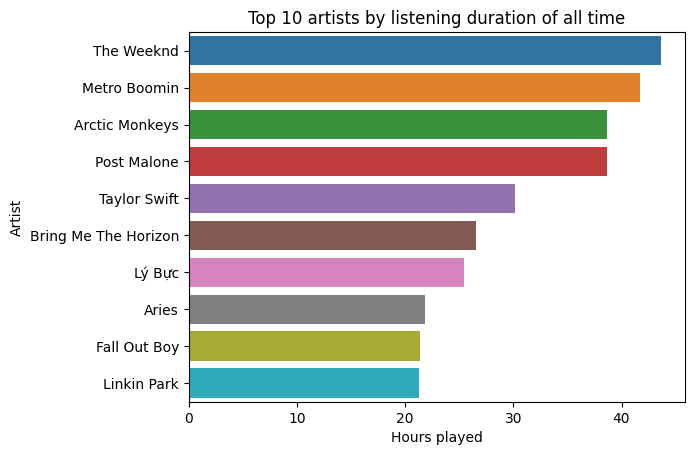

In [22]:

Q0_top10 = music_df.groupby('master_metadata_album_artist_name')['hours_played'].sum()
Q0_top10 = Q0_top10.sort_values(ascending=False).head(10)
Q0_top10 = Q0_top10.reset_index()


sns.barplot(
    data=Q0_top10,
    x=Q0_top10.hours_played,
    y=Q0_top10.master_metadata_album_artist_name,
    orient='h'
)
plt.xlabel('Hours played')
plt.ylabel('Artist')
plt.title('Top 10 artists by listening duration of all time')

## Question 1: With the data from 2020 to 2023, I would like to find out top 10 artists I listened to during each year (similar to a Spotify Wrapped)

In [58]:
def Q1_top_10_listening_time(year):
    Q1 = music_df[music_df['datetime'].apply(lambda t:t.year == year)]
    Q1 = Q1.groupby('master_metadata_album_artist_name')['hours_played'].sum().sort_values(ascending=False).head(10).reset_index()
 
    sns.barplot(
        data=Q1,
        x=Q1.hours_played,
        y=Q1.master_metadata_album_artist_name,
        orient='h'
    )
    plt.xlabel('Hours played')
    plt.ylabel('Artist')
    plt.title('Top 10 artists by listening time in ' + str(year))



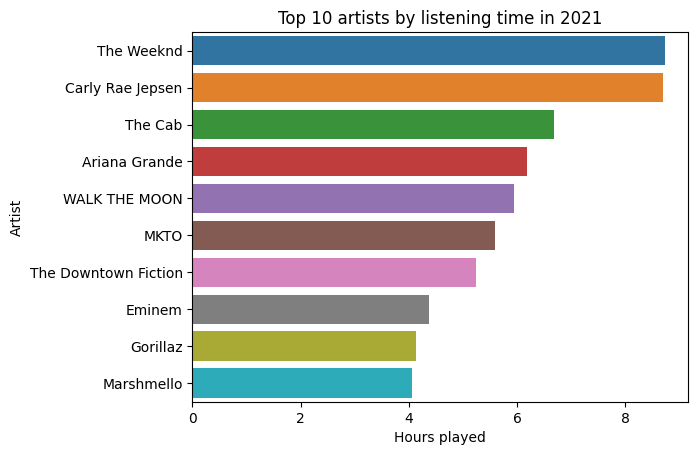

In [39]:
Q1_top_10_listening_time(2021)

# Question 2 - What were my favorite songs during those years?

In [51]:
Q2 = music_df[['master_metadata_track_name', 'master_metadata_album_artist_name','master_metadata_album_album_name', 'hours_played', 'datetime']]
# Perform lambda function to group by year
def favorite_10_songs(year):
    Q2_results = Q2[Q2['datetime'].apply(lambda t:t.year == year)]
    Q2_results = Q2_results.groupby(by=['master_metadata_track_name','master_metadata_album_artist_name']).sum('hours_played')
    Q2_results = Q2_results.sort_values('hours_played',ascending=False)[:10]
    return Q2_results

In [54]:
favorite_10_songs(2020)

,,hours_played
master_metadata_track_name,master_metadata_album_artist_name,
Re:Re: (Single ver.),ASIAN KUNG-FU GENERATION,5.504844
Re:Re:,ASIAN KUNG-FU GENERATION,4.579546
Open Door,Mike Shinoda,2.669939
WHAT YOU GONNA DO???,Bastille,2.279169
Bad Decisions,Bastille,1.974452
Quarter Past Midnight,Bastille,1.642454
星の奏でる歌 - Duet Ver.,椎名まゆり(cv.花澤香菜),1.597579
Doom Days,Bastille,1.517034
リライト,ASIAN KUNG-FU GENERATION,1.455168


# Question 3 - Albums on replay

Favorite album of all time from the beginning of my Spotify usage

In [56]:
album_listen_time = music_df.groupby('master_metadata_album_album_name').sum('hours_played').sort_values('hours_played', ascending=False)
album_top_10 = album_listen_time['hours_played'][:10].sort_values(ascending=True)

<BarContainer object of 10 artists>

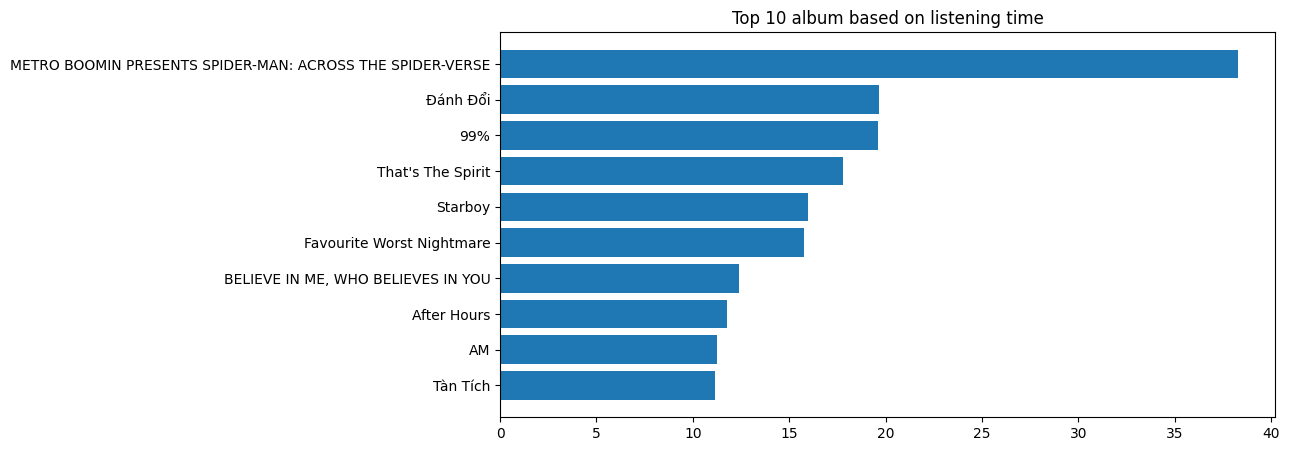

In [57]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Top 10 album based on listening time')
ax.barh(album_top_10.index, album_top_10)

# Question 4 - How much did I enjoy listening to my favorite artists over time?

In [60]:
# Determine top artists listened to.
Q4 = music_df.groupby(['master_metadata_album_artist_name'])[['hours_played']]
Q4 = Q4.sum().sort_values('hours_played', ascending=False)[:10]
top_artists = [artist for (artist) in Q4.index.values] #Return list of top artists

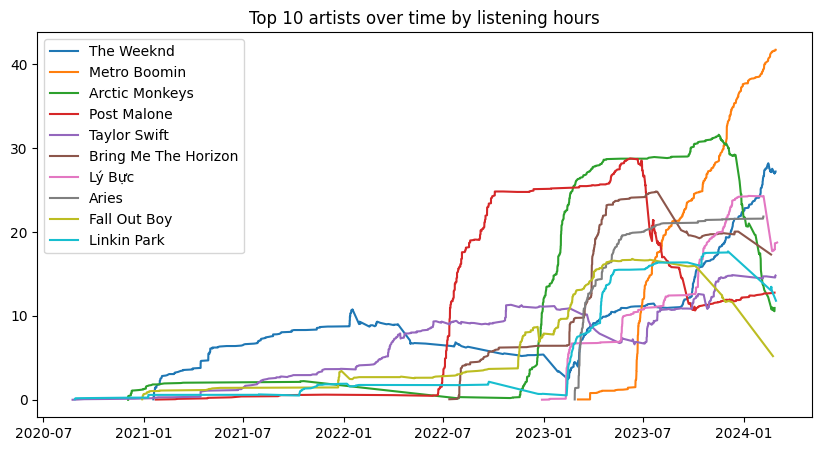

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))
for artist in top_artists:
  # Generate rolling sums of total amount of time listening to the artist.
  favorite_artist_over_time = music_df.loc[music_df['master_metadata_album_artist_name'] == artist][['datetime', 'hours_played']]
  favorite_artist_over_time = favorite_artist_over_time.sort_values('datetime')
  favorite_artist_over_time = favorite_artist_over_time.rolling('365D', on='datetime').sum()
  ax.plot(favorite_artist_over_time['datetime'], favorite_artist_over_time['hours_played'], label=artist)

ax.set_title('Top 10 artists over time by listening hours')
plt.legend()
plt.show()

# Question 5: Daily listening habit - Do I still use Spotify that much?

Data needed for this question: Hours played & Datetime

<BarContainer object of 44 artists>

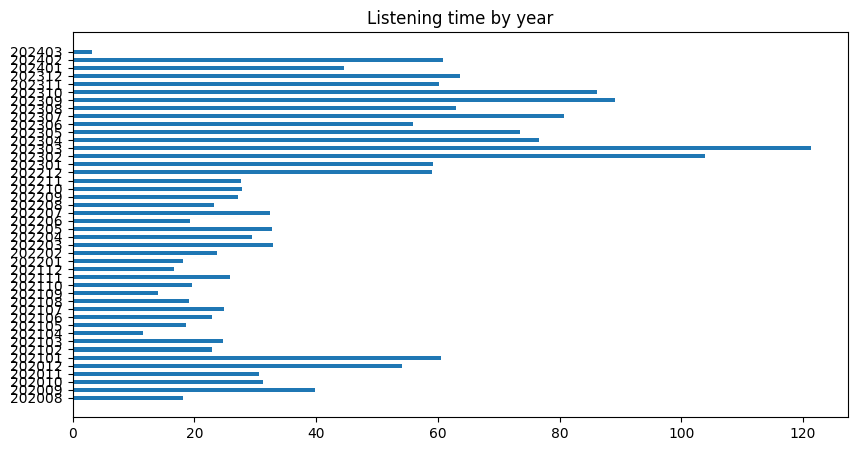

In [18]:
listening_habit = music_df[['datetime', 'hours_played']].copy()
listening_habit['local-time'] = listening_habit['datetime'].dt.tz_convert('Asia/Bangkok')
### Convert to GMT+7 to match my local time in VN
listening_habit['year-month'] = listening_habit['local-time'].dt.strftime('%Y%m')
listening_habit['hour'] = listening_habit['local-time'].dt.hour #formatted in 24 hours

# Plotting
listening_time = listening_habit.groupby('year-month')['hours_played'].sum()
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Listening time by year')
ax.barh(listening_time.index, listening_time, height=0.5)

# Question 6 - Time of the day that I listened on Spotify the most

Làm slide giống kiểu Spotify wrapped

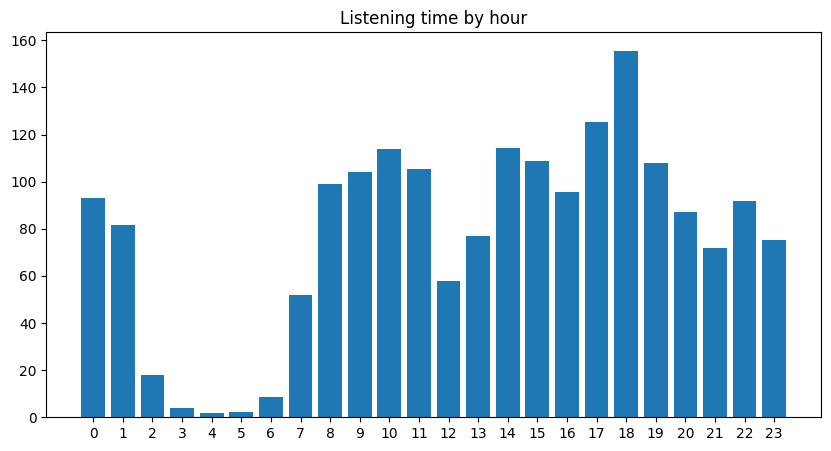

In [62]:
listening_time = listening_habit.groupby('hour')['hours_played'].sum()
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Listening time by hour')
ax.bar(listening_time.index, listening_time)
ax.xaxis.set_ticks(list(range(24)))

Huh, I listened to music from 3AM to 5AM? That seems like the time when I should be sleeping. What could I have been listening then?

In [139]:
Q6_add = music_df #Copy the df first
Q6_add['local_time'] = music_df['datetime'].dt.tz_convert('Asia/Bangkok') # Convert to GMT+7 to match my local time in VN
Q6_add['hour'] = Q6_add['local-time'].dt.hour #formatted in 24 hours
Q6_add = Q6_add[(Q6_add['hour'] > 1) & (Q6_add['hour'] < 6) & (Q6_add['master_metadata_track_name'] != 'None')]

In [145]:
music_df_early_morning = Q6_add.dropna(subset='spotify_track_uri')
music_df_early_morning[(music_df_early_morning['reason_end'] == 'trackdone') & (music_df_early_morning['reason_start'] != 'trackdone')]

,platform,ip_addr_decrypted,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,datetime,hours_played,local-time,hour,local_time
590,"Android OS 10 API 29 (vsmart, Live)",171.241.23.132,unknown,Who's It Gonna Be,BgA,Who's It Gonna Be,spotify:track:3j5jNUsc1gItB7iWtFKoL7,clickrow,trackdone,False,NaN,False,1599859650139,False,2020-09-11 21:30:51+00:00,0.055756,2020-09-12 04:30:51+07:00,4,2020-09-12 04:30:51+07:00
592,"Android OS 10 API 29 (vsmart, Live)",171.241.23.132,unknown,Re:Re: (Single ver.),ASIAN KUNG-FU GENERATION,Re: Re:,spotify:track:7gehOKSGfZgjIJSxiyE8oD,clickrow,trackdone,False,NaN,False,1599860090619,False,2020-09-11 21:40:23+00:00,0.092289,2020-09-12 04:40:23+07:00,4,2020-09-12 04:40:23+07:00
1323,"Android OS 10 API 29 (vsmart, Live)",103.7.36.102,unknown,WHAT YOU GONNA DO???,Bastille,WHAT YOU GONNA DO???,spotify:track:31brGBYDq5N15VxIn5juop,clickrow,trackdone,False,NaN,False,1603306717208,False,2020-10-21 19:00:49+00:00,0.036473,2020-10-22 02:00:49+07:00,2,2020-10-22 02:00:49+07:00
1326,Windows 10 (10.0.18363; x64; AppX),27.79.252.147,unknown,All I Wanna Do,Martin Jensen,All I Wanna Do,spotify:track:1Cq23W4ZxHTY8QbP40qjEc,clickrow,trackdone,False,NaN,False,1603307805165,False,2020-10-21 19:19:59+00:00,0.053989,2020-10-22 02:19:59+07:00,2,2020-10-22 02:19:59+07:00
1465,"Android OS 10 API 29 (vsmart, Live)",27.79.208.217,unknown,ninelie,Aimer,Daydream,spotify:track:6kQ9Os7x5LJ2jLHb8VWKaa,clickrow,trackdone,False,NaN,False,1604084172827,False,2020-10-30 19:23:50+00:00,0.072715,2020-10-31 02:23:50+07:00,2,2020-10-31 02:23:50+07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12271,android,171.224.178.136,unknown,The Lost Soul Down - Slowed & Reverb,NBSPLV,The Lost Soul Down,spotify:track:5XtsfMFmpM401S6dbVaOQw,clickrow,trackdone,False,False,False,1689707120,False,2023-07-18 19:09:57+00:00,0.066975,2023-07-19 02:09:57+07:00,2,2023-07-19 02:09:57+07:00
15219,android,171.224.180.152,unknown,bittersweet teeth,poptropicaslutz!,bittersweet teeth,spotify:track:0Uk24ctvr2GyVZ3aC3vGgA,clickrow,trackdone,False,False,False,1693768599,False,2023-09-03 19:18:57+00:00,0.039444,2023-09-04 02:18:57+07:00,2,2023-09-04 02:18:57+07:00
639,android,171.224.180.255,unknown,vaicaunoicokhiennguoithaydoi,GREY D,vaicaunoicokhiennguoithaydoi,spotify:track:25h0TqC9H3BcMA7KjK5nHK,appload,trackdone,False,False,False,1695680603,False,2023-09-25 22:23:48+00:00,0.007821,2023-09-26 05:23:48+07:00,5,2023-09-26 05:23:48+07:00
8369,ios,171.224.177.136,unknown,02 Mơ Làm Ma,Ngọt,Suýt 1,spotify:track:7Ebm9NxzNhUX2FxzBl1kwm,clickrow,trackdone,False,False,False,1708714819,False,2024-02-23 19:03:30+00:00,0.049200,2024-02-24 02:03:30+07:00,2,2024-02-24 02:03:30+07:00


# Question 7 - What can features like started, stopped bring insights?

In [63]:
# Q7 = music_df.drop(['ip_addr_decrypted', 'user_agent_decrypted'], inplace=False)
Q7[['reason_start', 'reason_end', 'shuffle', 'skipped']].describe()

NameError: name 'Q7' is not defined